![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import re
from textblob import TextBlob
from collections import Counter

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/worldcities-clean/worldcities_clean.csv


In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [4]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [5]:
DATA2_DIR = '/kaggle/input/worldcities-clean/'
cities = pd.read_csv(DATA2_DIR+'worldcities_clean.csv')
#Бесплатно распространяемая (как я понял) база с городами, странами и населением
#https://gist.github.com/curran/13d30e855d48cdd6f22acdf0afe27286/#file-worldcities_clean-csv

In [6]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
Restaurant_id        40000 non-null object
City                 40000 non-null object
Cuisine Style        30717 non-null object
Ranking              40000 non-null float64
Rating               40000 non-null float64
Price Range          26114 non-null object
Number of Reviews    37457 non-null float64
Reviews              40000 non-null object
URL_TA               40000 non-null object
ID_TA                40000 non-null object
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
Restaurant_id        10000 non-null object
City                 10000 non-null object
Cuisine Style        7693 non-null object
Ranking              10000 non-null float64
Price Range          6525 non-null object
Number of Reviews    9343 non-null float64
Reviews              9998 non-null object
URL_TA               10000 non-null object
ID_TA                10000 non-null object
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
df_test1=df_test.copy()

In [11]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
Restaurant_id    10000 non-null object
Rating           10000 non-null float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
Restaurant_id        50000 non-null object
City                 50000 non-null object
Cuisine Style        38410 non-null object
Ranking              50000 non-null float64
Price Range          32639 non-null object
Number of Reviews    46800 non-null float64
Reviews              49998 non-null object
URL_TA               50000 non-null object
ID_TA                50000 non-null object
sample               50000 non-null int64
Rating               50000 non-null float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

# 0. Функции

In [15]:
def Row_to_list(row):
    ''' Функция возвращает списком все, что  между '', кроме цифр '''
    pattern=re.compile("'(\D*?)'")
    return re.findall(pattern, str(row))

In [16]:
def Row_to_tuple(row):
    ''' Функция возвращает кортежом все, что  между '', кроме цифр '''
    pattern=re.compile("'(\D*?)'")
    return tuple(set(re.findall(pattern, str(row))))

In [17]:
def Row_to_date(row):
    '''Функция возвращает списком все похожее на паттерн даты'''
    pattern=re.compile('\d\d/\d\d/\d\d\d\d')
    return re.findall(pattern, str(row))

In [18]:
def PricetoRange(row):
    '''Функция заменяет рейтинг цен цифрами'''
    if row=='$': return 1
    elif row=='$$ - $$$': return 2
    elif row=='$$$$': return 3

In [19]:
def time_delta(row):
    ''' Вычисляет время между Reviews0 и Reviews1  в днях '''
    if pd.notna(row['Reviews_data0']) and pd.notna(row['Reviews_data1']):
        if row['Reviews_data0']<row['Reviews_data1']:
            return (row['Reviews_data1'] - row['Reviews_data0']).days
        else:
            return (row['Reviews_data0'] - row['Reviews_data1']).days
    else:
        return np.nan

## 1. Обработка NAN 
У наличия пропусков могут быть разные причины, но пропуски нужно либо заполнить, либо исключить из набора полностью. Но с пропусками нужно быть внимательным, **даже отсутствие информации может быть важным признаком!**   
По этому перед обработкой NAN лучше вынести информацию о наличии пропуска как отдельный признак 

In [20]:
# Для примера я возьму столбец Number of Reviews
data['Number_of_Reviews_isNAN'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [21]:
# Остальные колонки обработаем позднее

### 2. Обработка признаков
Для начала посмотрим какие признаки у нас могут быть категориальными.

In [22]:
data.nunique(dropna = False)

Restaurant_id              13094
City                          31
Cuisine Style              10732
Ranking                    12975
Price Range                    4
Number of Reviews           1574
Reviews                    41858
URL_TA                     49963
ID_TA                      49963
sample                         2
Rating                        10
Number_of_Reviews_isNAN        2
dtype: int64

### Поле Reviews

Разобъем поле Reviews на отдельные колонки содержащие отзывы и даты

In [23]:
# Заметив несколько случаев присутствия, заменяем парные кавычки  в Reviews одинарными
data['Reviews'] = data['Reviews'].str.replace(r"[\"]", r"'")

In [24]:
# Превращаем строковый тип поля  Reviews в  список отзывов без дат
data['Reviews_str'] = data['Reviews'].apply(Row_to_list)

In [25]:
#Для обработки  копируем столбец отзывов
Reviews=data['Reviews_str'].copy()

In [26]:
# Превращаем столбец в DF
Reviews = Reviews.apply(pd.Series)

In [27]:
# Удалим мусор, т.к.  отзывы находятся в первых двух колонках
del Reviews[2]
del Reviews[3]
del Reviews[4] 

In [28]:
#Переименуем колонки
Reviews=Reviews.rename(columns = {0: 'Reviews0', 1: 'Reviews1'})

In [29]:
Reviews.shape

(50000, 2)

In [30]:
#Присоединим получившиеся две колонки с отзывами к нашим данным
#data = data.merge(Reviews[['Reviews0', 'Reviews1']], left_index = True, right_index = True)
data = pd.concat([data, Reviews], axis=1)

In [31]:
data['Reviews']

0                                                 [[], []]
1        [['Very good reviews!', 'Fine dining in Hakani...
2        [['Better than the Links', 'Ivy Black'], ['12/...
3        [['Most exquisite', 'Delicious and authentic']...
4        [['Always the best in bratislava', 'Very good ...
                               ...                        
49995    [['The real Italian experience!', 'Wonderful f...
49996    [['Parisian atmosphere', 'Bit pricey but inter...
49997    [['Good by swedish standards', 'A hidden jewel...
49998    [['Underground restaurant', 'Oldest Restaurant...
49999    [['Average', 'Nice an informal'], ['01/31/2016...
Name: Reviews, Length: 50000, dtype: object

In [32]:
#Отберем список дат в отдельную колонку 
data['Reviews_dats'] = data['Reviews'].apply(Row_to_date)

In [33]:
data['Reviews_dats']

0                              []
1        [12/05/2017, 10/29/2017]
2        [12/28/2017, 12/06/2017]
3        [12/06/2017, 11/22/2017]
4        [02/08/2018, 01/24/2018]
                   ...           
49995    [12/16/2017, 11/12/2017]
49996    [12/21/2017, 12/12/2017]
49997    [11/03/2016, 04/12/2008]
49998    [07/11/2017, 06/18/2017]
49999    [01/31/2016, 07/04/2012]
Name: Reviews_dats, Length: 50000, dtype: object

In [34]:
# Превращаем список в DF
data[['Reviews_data0', 'Reviews_data1']] = data['Reviews_dats'].apply(pd.Series)

In [35]:
# Превратим строковые данные в тип datetime
data['Reviews_data0'] = pd.to_datetime(data['Reviews_data0'], errors='coerce')
data['Reviews_data1'] = pd.to_datetime(data['Reviews_data1'], errors='coerce')

In [36]:
#  удалим мусор
del data['Reviews']
del data['Reviews_str']
del data['Reviews_dats']

In [37]:
# Найдем разницу в датах
data['time_delta'] = data.apply(time_delta, axis=1)

In [38]:
data['NaN_Reviews0'] = pd.isna(data['Reviews_data0']).astype('uint8')

In [39]:
data['NaN_Reviews1'] = pd.isna(data['Reviews_data1']).astype('uint8')

In [40]:
#Заполним пропуски средним числом
mean_time_delta=data['time_delta'].mean()

In [41]:
data['time_delta'].fillna(mean_time_delta, inplace=True)

In [42]:
data['Reviews0'] = data['Reviews0'].fillna('')
data['Reviews1'] = data['Reviews1'].fillna('')

In [43]:
data['Review_0'] = data['Reviews0'].apply(lambda x: TextBlob(x).polarity)


In [44]:
data['Review_1'] = data['Reviews1'].apply(lambda x: TextBlob(x).polarity)

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
Restaurant_id              50000 non-null object
City                       50000 non-null object
Cuisine Style              38410 non-null object
Ranking                    50000 non-null float64
Price Range                32639 non-null object
Number of Reviews          46800 non-null float64
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Reviews0                   50000 non-null object
Reviews1                   50000 non-null object
Reviews_data0              41886 non-null datetime64[ns]
Reviews_data1              36206 non-null datetime64[ns]
time_delta                 50000 non-null float64
NaN_Reviews0               50000 non-null uint8
NaN_Reviews1               50000 non-null

### Поле Price Range

In [46]:
data['NaN_Price Range'] = pd.isna(data['Price Range']).astype('uint8')

In [47]:
# Переведем ранги цен из знаков  в цифры
data['Price Range'] = data['Price Range'].apply(PricetoRange)

In [48]:
# Пропуски в Price Range заполним средним по городу
men = data.groupby('City')['Price Range'].transform('mean')
data['Price Range'] = data['Price Range'].fillna(men)

In [49]:
#Округлим средние до целого
#data['Price Range']=data['Price Range'].astype('uint8')

### Поле City

Присоединим поля из cities с названиями стран и количеством населения в городаж к нашему датасету

In [50]:
#Очистим названия городов от пробелов и приведем к нижнему регистру
data.City=data.City.str.lower()
data.City=data.City.str.strip()

In [51]:
#Приведем  колонки к единобразному названию 
cities=cities.rename(columns={'city': 'City', 'country': 'Country', 'population': 'Population'})

In [52]:
cities.City=cities.City.str.lower()
cities.City=cities.City.str.strip()

In [53]:
#Имеются дубликаты назаний городов, что приведет к дублированию строк после merge
cities.City[cities.City.duplicated()==True]

265          suzhou
291        santiago
322       hyderabad
396      vila velha
520           natal
           ...     
4576         mérida
4581       hamilton
4613    saint cloud
4640       trujillo
4645       lakewood
Name: City, Length: 158, dtype: object

In [54]:
#Оставим только крупнейшие города из дубликатов 
cities=cities.sort_values(by='Population', ascending=False).groupby('City', as_index=False).first()

In [55]:
#Объединим таблицы по колонке City
data=data.merge(cities, on='City', how='left')

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 25 columns):
Restaurant_id              50000 non-null object
City                       50000 non-null object
Cuisine Style              38410 non-null object
Ranking                    50000 non-null float64
Price Range                50000 non-null float64
Number of Reviews          46800 non-null float64
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Reviews0                   50000 non-null object
Reviews1                   50000 non-null object
Reviews_data0              41886 non-null datetime64[ns]
Reviews_data1              36206 non-null datetime64[ns]
time_delta                 50000 non-null float64
NaN_Reviews0               50000 non-null uint8
NaN_Reviews1               50000 non-nul

### Поле Cuisine Style

In [57]:
# Превращаем строковый тип поля Cuisine Style в список кухонь
data['Cuisine Style']=data['Cuisine Style'].apply(Row_to_tuple)

In [58]:
# Заменим в поле Cuisine Style записи типа [[],[]] на np.nan
data['Cuisine Style']=data['Cuisine Style'].apply(lambda row: row if len(row)!=0  else np.nan)

In [59]:
data['NaN_Cuisine Style'] = pd.isna(data['Cuisine Style']).astype('uint8')

In [60]:
#data.loc[data['Cuisine Style'].isnull(), 'Cuisine Style'] = data.groupby('City').transform('mean')

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 26 columns):
Restaurant_id              50000 non-null object
City                       50000 non-null object
Cuisine Style              38410 non-null object
Ranking                    50000 non-null float64
Price Range                50000 non-null float64
Number of Reviews          46800 non-null float64
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Reviews0                   50000 non-null object
Reviews1                   50000 non-null object
Reviews_data0              41886 non-null datetime64[ns]
Reviews_data1              36206 non-null datetime64[ns]
time_delta                 50000 non-null float64
NaN_Reviews0               50000 non-null uint8
NaN_Reviews1               50000 non-nul

Далее очень коряво, но я оставил свое решение по заполнению 'Cuisine Style' наиболее часто втречающимися значениями по городам

In [62]:
# Соберем в отдельную таблицу наиболее часто встречающуюся кухню в странах
mod = data.groupby('City')['Cuisine Style'].apply(pd.Series.mode).reset_index()

In [63]:
del mod['level_1']

In [64]:
mod

,City,Cuisine Style
0,amsterdam,"(European, Dutch)"
1,athens,"(Greek,)"
2,barcelona,"(Spanish,)"
3,berlin,"(Italian,)"
4,bratislava,"(Pub,)"
5,brussels,"(Belgian, European)"
6,budapest,"(Hungarian, European)"
7,copenhagen,"(Scandinavian, European, Danish)"
8,dublin,"(Irish, Pub, Bar)"
9,edinburgh,"(Cafe,)"


In [65]:
mod.drop_duplicates(inplace=True)

In [66]:
mod

,City,Cuisine Style
0,amsterdam,"(European, Dutch)"
1,athens,"(Greek,)"
2,barcelona,"(Spanish,)"
3,berlin,"(Italian,)"
4,bratislava,"(Pub,)"
5,brussels,"(Belgian, European)"
6,budapest,"(Hungarian, European)"
7,copenhagen,"(Scandinavian, European, Danish)"
8,dublin,"(Irish, Pub, Bar)"
9,edinburgh,"(Cafe,)"


In [67]:
#Присоединим к наим данным, видим  что получилось новое поле с названием  Cuisine Style_x и Cuisine Style_y
data = data.merge(mod, on = 'City', how = 'left')

In [68]:
data.sample(10)

,Restaurant_id,City,Cuisine Style_x,Ranking,Price Range,Number of Reviews,URL_TA,ID_TA,sample,Rating,...,NaN_Reviews1,Review_0,Review_1,NaN_Price Range,lat,lng,Country,Population,NaN_Cuisine Style,Cuisine Style_y
39968,id_1331,dublin,"(Cafe, Vegetarian Friendly)",1334.0,2.000000,33.0,/Restaurant_Review-g186605-d6965386-Reviews-Th...,d6965386,1,4.0,...,0,0.000000,0.910000,0,53.3331,-6.2489,Ireland,1059000.0,0,"(Irish, Pub, Bar)"
17711,id_8971,london,"(British,)",8980.0,1.808891,2.0,/Restaurant_Review-g186338-d7597135-Reviews-Se...,d7597135,1,5.0,...,0,0.000000,0.000000,1,51.5000,-0.1167,United Kingdom,8567000.0,0,"(Pub, Bar, British)"
17934,id_3463,rome,"(Sushi, Asian, Seafood, Japanese)",3464.0,2.000000,178.0,/Restaurant_Review-g187791-d799462-Reviews-Nag...,d799462,1,4.0,...,0,0.390000,0.000000,0,41.8960,12.4833,Italy,3339000.0,0,"(Italian,)"
24036,id_206,edinburgh,"(Vegan Options, Vegetarian Friendly, Gluten Fr...",207.0,2.000000,320.0,/Restaurant_Review-g186525-d1316486-Reviews-Da...,d1316486,1,4.5,...,0,0.000000,0.000000,0,55.9483,-3.2191,United Kingdom,504966.0,0,"(Cafe,)"
29325,id_11278,paris,NaN,11280.0,1.891774,3.0,/Restaurant_Review-g187147-d11785599-Reviews-D...,d11785599,1,4.0,...,1,0.000000,0.000000,1,48.8667,2.3333,France,9904000.0,1,"(French,)"
26432,id_1627,madrid,NaN,1629.0,1.849199,45.0,/Restaurant_Review-g187514-d8672298-Reviews-XA...,d8672298,1,4.5,...,0,0.583333,0.156250,1,40.4000,-3.6834,Spain,5567000.0,1,"(Spanish,)"
28207,id_482,rome,"(Gluten Free Options, Seafood, European, Medit...",483.0,3.000000,481.0,/Restaurant_Review-g187791-d1012248-Reviews-Ai...,d1012248,1,4.5,...,0,0.800000,0.000000,0,41.8960,12.4833,Italy,3339000.0,0,"(Italian,)"
32909,id_795,krakow,NaN,796.0,1.652520,7.0,/Restaurant_Review-g274772-d12363461-Reviews-R...,d12363461,1,4.0,...,0,0.333333,0.333333,1,NaN,NaN,NaN,NaN,1,"(European, Polish)"
45606,id_536,lisbon,"(Vegetarian Friendly, European, International,...",537.0,3.000000,168.0,/Restaurant_Review-g189158-d1045677-Reviews-Te...,d1045677,1,4.0,...,0,0.000000,-1.000000,0,38.7227,-9.1449,Portugal,2812000.0,0,"(European, Portuguese)"
32645,id_379,oslo,"(Asian, Chinese)",380.0,2.000000,38.0,/Restaurant_Review-g190479-d1400157-Reviews-Da...,d1400157,1,4.0,...,0,1.000000,0.687500,0,59.9167,10.7500,Norway,835000.0,0,"(Pub,)"


In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 27 columns):
Restaurant_id              50000 non-null object
City                       50000 non-null object
Cuisine Style_x            38410 non-null object
Ranking                    50000 non-null float64
Price Range                50000 non-null float64
Number of Reviews          46800 non-null float64
URL_TA                     50000 non-null object
ID_TA                      50000 non-null object
sample                     50000 non-null int64
Rating                     50000 non-null float64
Number_of_Reviews_isNAN    50000 non-null uint8
Reviews0                   50000 non-null object
Reviews1                   50000 non-null object
Reviews_data0              41886 non-null datetime64[ns]
Reviews_data1              36206 non-null datetime64[ns]
time_delta                 50000 non-null float64
NaN_Reviews0               50000 non-null uint8
NaN_Reviews1               50000 non-nul

In [70]:
#Переименуем обратно нашу колонку
data=data.rename(columns = {'Cuisine Style_x': 'Cuisine Style'})

In [71]:
#Коряво, но следующая строка сработала  только с пробелами, поэтому сделаем пробелы, вместо NaN 
data['Cuisine Style'] = data['Cuisine Style'].fillna('')

In [72]:
#Заменяем отсутствующие значения (пробелы) на моду по кухням по городам из Cuisine Style_y
data['Cuisine Style'] = data.apply(lambda row: row['Cuisine Style_y'] if row['Cuisine Style'] == '' else row['Cuisine Style'], axis = 1)

In [73]:
# Удалим не нужный столбец
del data['Cuisine Style_y']

In [74]:
#len(Counter(data['Cuisine Style'].sum()))

In [75]:
data['Cuisine Style'].isnull().sum()

0

In [76]:
data['lat'] = data['lat'].fillna(0)
data['lng'] = data['lng'].fillna(0)

In [77]:
# Создадим новый признак с количеством кухонь
data['num_cuisine'] = data['Cuisine Style'].apply(len)

### Заполним пропуски в полях Country и Population

In [78]:
# В странах и численности жителей есть пропуски
data.City[data.Population.isna()].value_counts()

copenhagen    819
zurich        685
oporto        642
krakow        554
Name: City, dtype: int64

In [79]:
# Создадим вручную словарь с данными 
county_set={'copenhagen': 'Denmark', 'zurich': 'Switzerland', 'oporto': 'Portugal', 'krakow' : 'Poland'}
population_set= {'copenhagen' : 602481, 'zurich' : 402762, 'oporto': 214349, 'krakow': 766683}

In [80]:
# Заполним данными из словаря
mask = data['Country'].astype('str').isin(['NaN','nan'])
data.loc[mask, 'Country'] = data.loc[mask, 'City'].map(county_set)

In [81]:
mask = data['Population'].astype('str').isin(['NaN','nan'])
data.loc[mask, 'Population'] = data.loc[mask, 'City'].map(population_set)

### Поле Number of Reviews

In [82]:
# Пропуски в Number of Reviews заполним средним по городу
men = data.groupby('City')['Number of Reviews'].transform('mean')
data['Number of Reviews']=data['Number of Reviews'].fillna(men)

In [83]:
data['Number_of_Reviews_by_Populat']=data['Number of Reviews']/data['Population']

### Посмотрим распределение признака

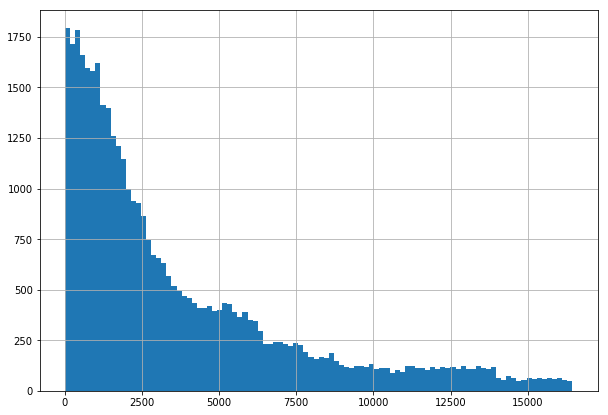

In [84]:
plt.rcParams['figure.figsize'] = (10,7)
df_train['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

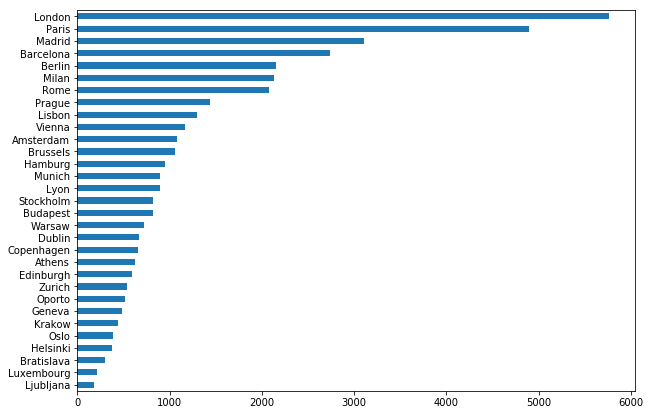

In [85]:
df_train['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

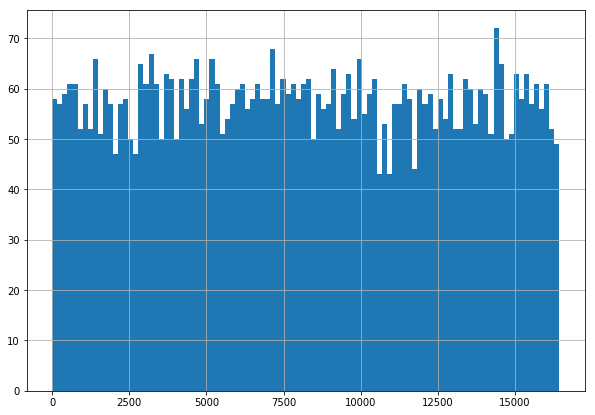

In [86]:
df_train['Ranking'][df_train['City'] =='London'].hist(bins=100)

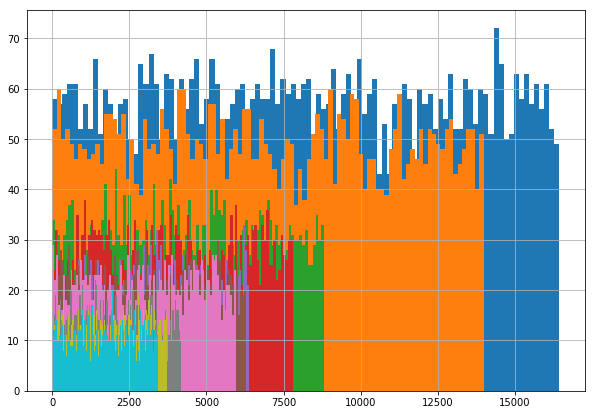

In [87]:
# посмотрим на топ 10 городов
for x in (df_train['City'].value_counts())[0:10].index:
    df_train['Ranking'][df_train['City'] == x].hist(bins=100)
plt.show()

****Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за мы этого имеем смещение.

>Подумайте как из этого можно сделать признак для вашей модели. Я покажу вам пример, как визуализация помогает находить взаимосвязи. А далее действуйте без подсказок =) 


### Поле Ranking (число отзывов) отцентрируем по среднему и поделим на количество ресторанов в городе

In [88]:
data['Ranking_by_Populat']=data['Ranking']/data['Population']

In [89]:
mean_Ranking = data.groupby(['City'])['Ranking'].mean()
count_Restorant = data['City'].value_counts(ascending=False)
data['mean_Ranking'] = data['City'].apply(lambda x: mean_Ranking[x])
data['count_Restorant'] = data['City'].apply(lambda x: count_Restorant[x])
data['Ranking_weighed'] = (data['Ranking'] - data['mean_Ranking']) / data['count_Restorant']

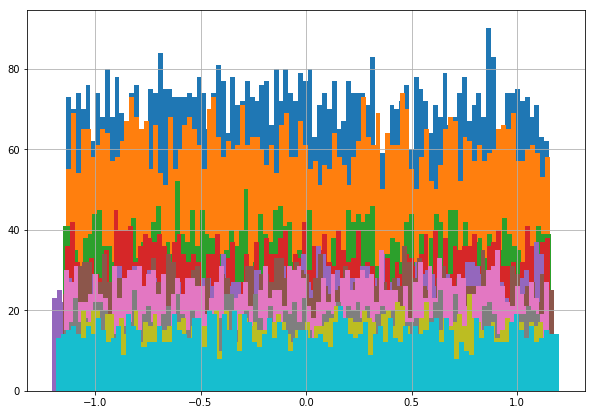

In [90]:
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking_weighed'][data['City'] == x].hist(bins=100)
plt.show()

Для кодирования категориальных признаков есть множество подходов:
* Label Encoding
* One-Hot Encoding
* Target Encoding
* Hashing

Выбор кодирования зависит от признака и выбраной модели.
Не будем сейчас сильно погружаться в эту тематику, давайте посмотрим лучше пример с One-Hot Encoding:
![](https://i.imgur.com/mtimFxh.png)

In [91]:
data

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,URL_TA,ID_TA,sample,Rating,...,lng,Country,Population,NaN_Cuisine Style,num_cuisine,Number_of_Reviews_by_Populat,Ranking_by_Populat,mean_Ranking,count_Restorant,Ranking_weighed
0,id_0,paris,"(Pub, Bar)",12963.0,2.000000,4.0,/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918,0,0.0,...,2.3333,France,9904000.0,0,2,4.038772e-07,0.001309,6938.557138,6108,0.986320
1,id_1,helsinki,"(Vegan Options, Gluten Free Options, Vegetaria...",106.0,2.000000,97.0,/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944,0,0.0,...,24.9341,Finland,1115000.0,0,5,8.699552e-05,0.000095,564.231579,475,-0.964698
2,id_2,edinburgh,"(Vegetarian Friendly,)",810.0,2.000000,28.0,/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638,0,0.0,...,-3.2191,United Kingdom,504966.0,0,1,5.544928e-05,0.001604,885.130201,745,-0.100846
3,id_3,london,"(Gluten Free Options, Vegetarian Friendly, Eur...",1669.0,3.000000,202.0,/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417,0,0.0,...,-0.1167,United Kingdom,8567000.0,0,5,2.357885e-05,0.000195,8169.707354,7193,-0.903755
4,id_4,bratislava,"(Gluten Free Options, Seafood, Vegetarian Frie...",37.0,3.000000,162.0,/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354,0,0.0,...,17.1170,Slovakia,423737.0,0,6,3.823126e-04,0.000087,462.428947,380,-1.119550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,id_499,milan,"(Vegan Options, Vegetarian Friendly, Gluten Fr...",500.0,2.000000,79.0,/Restaurant_Review-g187849-d2104414-Reviews-Ro...,d2104414,1,4.5,...,9.2050,Italy,2945000.0,0,4,2.682513e-05,0.000170,3106.027840,2694,-0.967345
49996,id_6340,paris,"(Vegetarian Friendly, Bar, French, American, E...",6341.0,2.000000,542.0,/Restaurant_Review-g187147-d1800036-Reviews-La...,d1800036,1,3.5,...,2.3333,France,9904000.0,0,5,5.472536e-05,0.000640,6938.557138,6108,-0.097832
49997,id_1649,stockholm,"(Sushi, Japanese)",1652.0,1.942238,4.0,/Restaurant_Review-g189852-d947615-Reviews-Sus...,d947615,1,4.5,...,18.0973,Sweden,1264000.0,0,2,3.164557e-06,0.001307,1237.482091,1033,0.401276
49998,id_640,warsaw,"(Eastern European, Vegetarian Friendly, Polish...",641.0,2.000000,70.0,/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,1,4.0,...,21.0000,Poland,1707000.0,0,5,4.100762e-05,0.000376,1055.193514,925,-0.447777


In [92]:
# для One-Hot Encoding в pandas есть готовая функция - get_dummies. Особенно радует параметр dummy_na
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)
#data = pd.get_dummies(data, columns=[ 'Country',], dummy_na=True)

### Посмотрим распределение целевой переменной

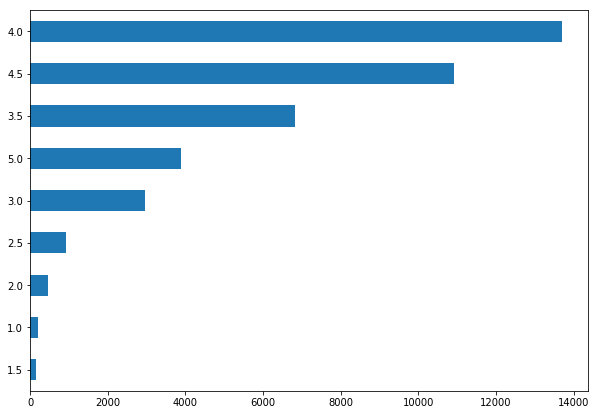

In [93]:
df_train['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

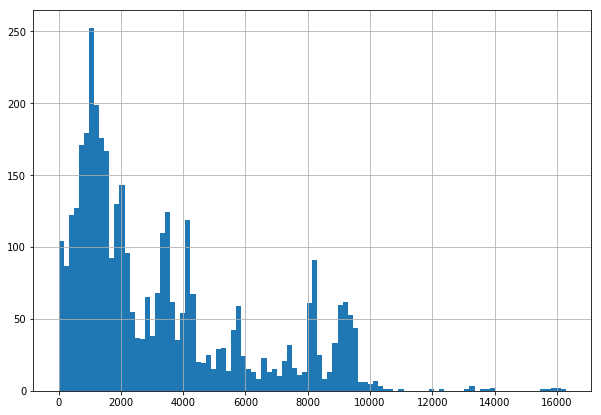

In [94]:
df_train['Ranking'][df_train['Rating'] == 5].hist(bins=100)

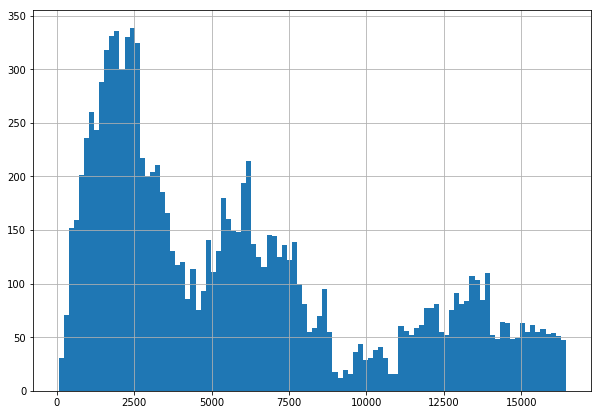

In [95]:
df_train['Ranking'][df_train['Rating'] < 4].hist(bins=100)

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [96]:
del data['Restaurant_id']
del data['Cuisine Style']
del data['URL_TA']
del data['ID_TA']
del data['Reviews0']
del data['Reviews1']
del data['Reviews_data0']
del data['Reviews_data1']
del data['City_nan']
del data['Country']
del data['mean_Ranking']
del data['count_Restorant']


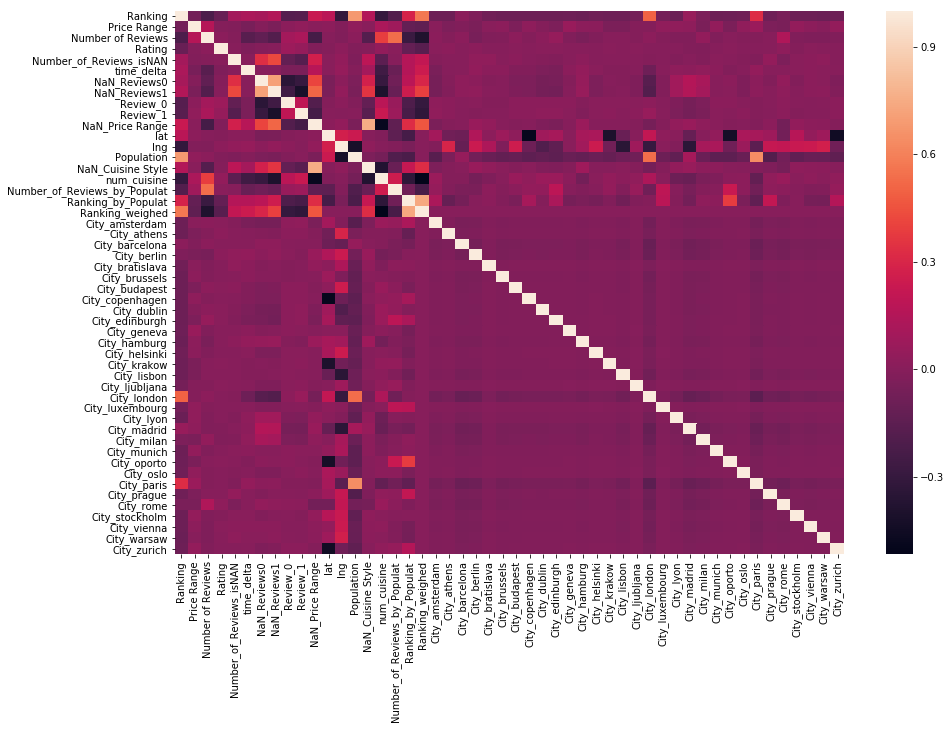

In [97]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(),)

Вообще благодаря визуализации в этом датасете можно узнать много интересных фактов, например:
* где больше Пицерий в Мадриде или Лондоне?
* в каком городе кухня ресторанов более разнообразна?

придумайте свои вопрос и найдите на него ответ в данных)

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 51 columns):
Ranking                         50000 non-null float64
Price Range                     50000 non-null float64
Number of Reviews               50000 non-null float64
sample                          50000 non-null int64
Rating                          50000 non-null float64
Number_of_Reviews_isNAN         50000 non-null uint8
time_delta                      50000 non-null float64
NaN_Reviews0                    50000 non-null uint8
NaN_Reviews1                    50000 non-null uint8
Review_0                        50000 non-null float64
Review_1                        50000 non-null float64
NaN_Price Range                 50000 non-null uint8
lat                             50000 non-null float64
lng                             50000 non-null float64
Population                      50000 non-null float64
NaN_Cuisine Style               50000 non-null uint8
num_cuisine            

#### Запускаем и проверяем что получилось

In [99]:
df_preproc = data


In [100]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [101]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [102]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 50), (40000, 50), (40000, 49), (32000, 49), (8000, 49))

# Model 
Сам ML

In [103]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [104]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [105]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [106]:
# Округлим до 0.5 полученные значения рейтинга
y_pred = (y_pred * 2).round()/2
y_pred

array([4.5, 5. , 4. , ..., 4.5, 4.5, 4. ])

In [107]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.17175


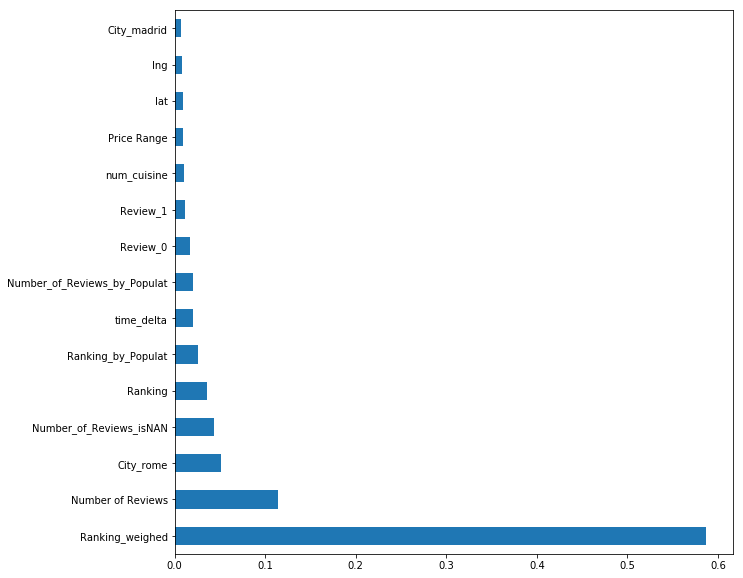

In [108]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission
Если все устраевает - готовим Submission на кагл

In [109]:
test_data.head(5)

,Ranking,Price Range,Number of Reviews,Rating,Number_of_Reviews_isNAN,time_delta,NaN_Reviews0,NaN_Reviews1,Review_0,Review_1,...,City_munich,City_oporto,City_oslo,City_paris,City_prague,City_rome,City_stockholm,City_vienna,City_warsaw,City_zurich
0,12963.0,2.0,4.0,0.0,0,142.548832,1,1,0.00,0.000000,...,0,0,0,1,0,0,0,0,0,0
1,106.0,2.0,97.0,0.0,0,37.000000,0,0,1.00,0.416667,...,0,0,0,0,0,0,0,0,0,0
2,810.0,2.0,28.0,0.0,0,22.000000,0,0,0.50,-0.166667,...,0,0,0,0,0,0,0,0,0,0
3,1669.0,3.0,202.0,0.0,0,14.000000,0,0,0.75,0.750000,...,0,0,0,0,0,0,0,0,0,0
4,37.0,3.0,162.0,0.0,0,15.000000,0,0,1.00,0.910000,...,0,0,0,0,0,0,0,0,0,0


In [110]:
test_data = test_data.drop(['Rating'], axis=1)

In [111]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [112]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [113]:
predict_submission = (predict_submission * 2).round()/2

In [114]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.0
1,id_1,4.5
2,id_2,4.5
3,id_3,4.0
4,id_4,4.5
5,id_5,4.5
6,id_6,2.5
7,id_7,2.5
8,id_8,4.0
9,id_9,4.5


# What's next?
Или что делать, чтоб улучшить результат:
* Обработать оставшиеся признаки в понятный для машины формат
* Посмотреть, что еще можно извлечь из признаков
* Сгенерировать новые признаки
* Подгрузить дополнительные данные, например: по населению или благосостоянию городов
* Подобрать состав признаков

В общем, процесс творческий и весьма увлекательный! Удачи в соревновании!
